In [3]:
# 1 번 셀 --------------------------------
# import copy
# import shutil
# import pandas as pd
# import glob
# import time
# import numpy as np
# import torch.nn as nn
# from torchvision.transforms import ToTensor
# import torchvision.models as models

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 2 번 셀 --------------------------------
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose(
                [
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
            "val": transforms.Compose(
                [
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)


In [5]:
# 3 번 셀 --------------------------------
cat_directory = r"C:\chungnam_chatbot\pytorch\data\dogs-vs-cats\Cat"
dog_directory = r"C:\chungnam_chatbot\pytorch\data\dogs-vs-cats\Dog"

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

# [[], []] -> [....]
# cat_images_filepaths.extend(dog_images_filepaths)
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

# 에러 처리.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_image_filepaths = correct_images_filepaths[:400]
val_image_filepaths = correct_images_filepaths[400:-10]
test_image_filepaths = correct_images_filepaths[-10:]
print(len(train_image_filepaths), len(val_image_filepaths), len(test_image_filepaths))

400 92 10


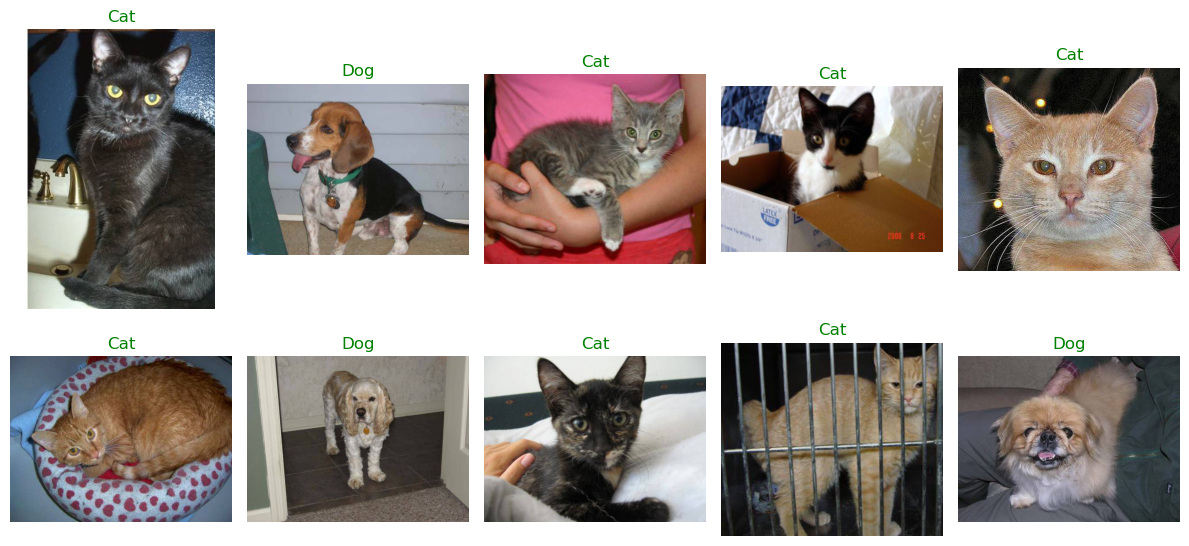

In [6]:
# 4 번 셀 --------------------------------
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
display_image_grid(test_image_filepaths)

In [7]:
# 5 번 셀 --------------------------------
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, tranform=None, phase="train") -> None:
        super().__init__()
        self.file_list = file_list
        self.transform = tranform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split("/")[-1].split(".")[0]
        if label == "dog":
            label = 1
        elif label == "cat":
            label = 0
        return img_transformed, label

In [8]:
# 6 번 셀 --------------------------------
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(
    train_image_filepaths, tranform = ImageTransform(size, mean, std), phase="train"
)

val_dataset = DogvsCatDataset(
    val_image_filepaths, tranform = ImageTransform(size, mean, std), phase="val"
)
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
C:\chungnam_chatbot\pytorch\data\dogs-vs-cats\Cat\cat
